In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import operator
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 

### Import the data

In [2]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


### Makes lists of the different types

In [3]:
ordinal = ["age"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased", "readmitted_tf"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["time_in_hospital"]

### Dataframes of each type of data

In [4]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

### Make Age ordinal

In [5]:
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

### Making all categorical columns categorical

In [6]:
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(int)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


In [7]:
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")

Done


### Function for setting up the training, validation, and test sets

In [8]:
def tvt_split(df_x, df_y, valid_size, t_size, seed):
    #doing the math because we have to split 2 seperate times
    valid_size = 100*valid_size/(100*(1-t_size))
    #First splitting out the test set
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = t_size, random_state=seed)
    #Splitting the training set into train/validate
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = valid_size, random_state=seed)

    #Reseting allof the indices
    x_train.reset_index()
    y_train.reset_index()
    x_test.reset_index()
    y_test.reset_index()
    x_valid.reset_index()
    y_valid.reset_index()

    return x_train, x_valid, x_test, y_train, y_valid, y_test

### Amount of correlation, after doing hot encoding, sorted

In [9]:
df_zg_corr = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, df_zg_response], axis = 1)
cors = df_zg_corr.corr()
cors = cors.sort_values(by=['time_in_hospital'])
cors.time_in_hospital

discharge_disposition_id_1                            -0.315089
change_No                                             -0.107939
diabetesMed_No                                        -0.092798
diag_2_val_Diabeties                                  -0.085539
admission_source_id_1                                 -0.073100
diag_3_val_Diabeties                                  -0.069658
medical_specialty_Cardiology                          -0.069329
admission_source_id_2                                 -0.067309
diag_3_val_None                                       -0.065543
admission_type_id_4                                   -0.065036
admission_type_id_3                                   -0.063714
A1Cresult_None                                        -0.053838
admission_type_id_5                                   -0.037537
discharge_disposition_id_2                            -0.036202
diag_1_val_Musculoskeletal                            -0.035738
medical_specialty_ObstetricsandGynecolog

### Make dataframe of columns that had correlation >= |0.1|

In [55]:
nm = ["num_medications", "discharge_disposition_id", "num_procedures", "number_diagnoses",
     "num_lab_procedures", "meds_increased", "admission_source_id", "readmitted_tf",
     "change", "age"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA['discharge_disposition_id'] = df_zg_minPCA['discharge_disposition_id'].astype(object)
df_zg_minPCA['admission_source_id'] = df_zg_minPCA['admission_source_id'].astype(object)
df_zg_minPCA['meds_increased'] = df_zg_minPCA['meds_increased'].astype(object)
df_zg_minPCA['readmitted_tf'] = df_zg_minPCA['readmitted_tf'].astype(object)
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

### Correlation of just the ones that are most highly correlated (with hot encoding)

In [56]:
pd.concat([df_zg_minPCA, df_zg_y], axis = 1).corr()["time_in_hospital"]

num_medications                0.372413
num_procedures                 0.225414
number_diagnoses               0.214656
num_lab_procedures             0.192700
discharge_disposition_id_1    -0.315089
discharge_disposition_id_2    -0.036202
discharge_disposition_id_3     0.137963
discharge_disposition_id_4     0.016493
discharge_disposition_id_5     0.032898
discharge_disposition_id_6     0.096999
discharge_disposition_id_7     0.158353
discharge_disposition_id_8     0.007743
discharge_disposition_id_9    -0.003179
discharge_disposition_id_10    0.003832
discharge_disposition_id_11    0.008310
discharge_disposition_id_12   -0.001586
discharge_disposition_id_13    0.027952
discharge_disposition_id_14    0.016902
discharge_disposition_id_15    0.009787
discharge_disposition_id_16   -0.001940
discharge_disposition_id_17    0.004969
discharge_disposition_id_18    0.039871
discharge_disposition_id_19   -0.007616
discharge_disposition_id_20   -0.000126
discharge_disposition_id_22    0.048168


# Linear Regression with variables based on correlation >= |0.1|

In [57]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_minPCA, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

Wall time: 246 ms


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


### Linear Regression

In [58]:
%%time
from sklearn.linear_model import LinearRegression
linearRegressor = LinearRegression()
linearRegressor.fit(x_t , y_t)

Wall time: 105 ms


In [59]:
%%time
#Find the optimal cutoff point
y_pred = linearRegressor.predict(x_tst)

#Calculate the MSE
error = mean_squared_error(y_tst, y_pred)

#Printing the results
print("MSE:", error)

MSE: 9.308022017195026e+21
Wall time: 3.97 ms


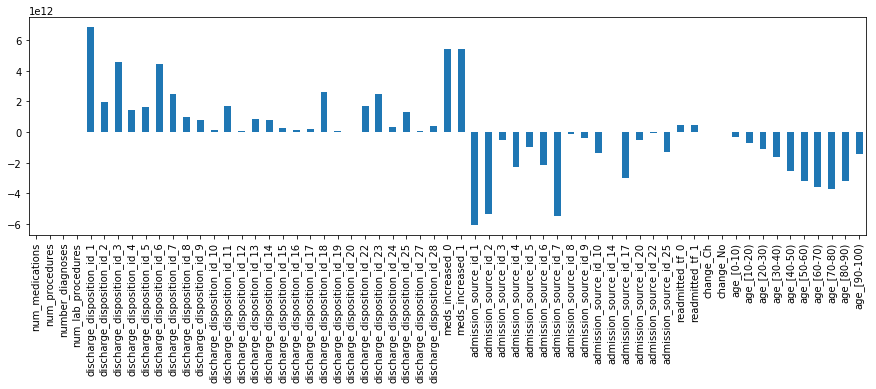

In [60]:
pd.Series(linearRegressor.coef_[0].T, index = x_train.columns).plot(kind = 'bar', figsize=(15,4))
plt.show()